# Implicit attention

The attention mechanism is very intuitive, and its definition could be generally speaking ''ignoring unnecessary information'', or ''attending to necessary information''.
This is true that we as human beings do that too: when we talk to someone we attend to what he/she says and not to other noises around us. (we will get back to this example!)

Any machine learning task to be successful needs attention to important/informative inputs; machine learning models require to pick up this attention somehow to deliver a good performance, and actually we may say if a machine learning model is working well it means that it somehow figured out how to learn to attend to necessary information. This is called *implicit attention*, which means the model learns to attend properly without ''explicitly'' designing any attention setup.

Let's take a simple linear regression model into account:

$$ Y = W^T X + b$$
what does this model do? it simply assigns some weights to different input attributes and sum them up (and maybe later apply a function like softmax to convert it to a probability). Let's take an example where there is a lot of attribute but only some of them are informative.

Let's use the MNIST dataset




## Getting MNIST data

In [1]:
from src.data_builder import mnist
mnist_data = mnist.MNIST()

ModuleNotFoundError: No module named 'torch'

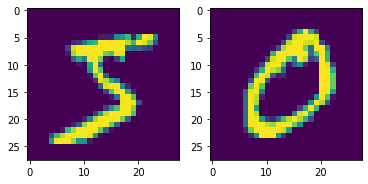

In [3]:
from src.visualization.plotting import image_plotting
image_plotting([mnist_data.train_set.data[0],mnist_data.train_set.data[1]])

To recognize the digit, we don't need to attend to all the pixels, many of the pixels around the images are zero and not informative.

Thus, if we train a linear model and the model does a good job in recognizing the digits, it must have figured out to attend to the informative pixels in the center of the image. The goal in the next step is to utilize such a linear model to explain this implicit attention.

*Let's try it then*

## Setting up the experiment data

For the sake of demonstration we only take 2 classes of the digits.

In [5]:
from torch.utils.data import DataLoader
from src.models import linear_model, trainer, cnn
from src.data_builder import mnist
import torch
from torch import optim
import matplotlib.pyplot as plt


mnist_data = mnist.MNIST(flatten=True)
subset_data = mnist_data.subset_traindata(labels=[7,9])
train_loader = DataLoader(subset_data, batch_size=64, shuffle=True)

## Modeling a linear (binary) classifier

Now we set up a linear binary classifier using pytorch:

In [6]:

lm = linear_model.LinearClassifier(dim=28, num_output=2)
optimizer = optim.Adagrad(lm.parameters(), lr=0.01, weight_decay=1e-1)
criterion = torch.nn.CrossEntropyLoss()

In [7]:
model_trainer = trainer.Trainer(model=lm, optimizer=optimizer,
                  criterion=criterion, train_data=train_loader, num_epoch = 10, vectorized=True)
model_trainer.run(verbose=0)

As we discussed above, the weights in a linear  model reflects how the model attends to the input features implicitly. So let's visualize the weights:

**NOTE**: in this model we have two classes and two output nodes, and therefore we have two sets of weights each maps the pixels to one of the output nodes.

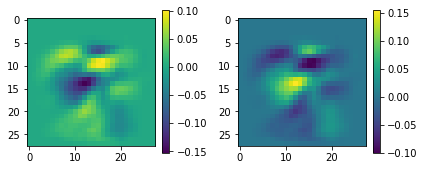

In [8]:
weights = list(lm.get_parameters())[0]
fig, ax = plt.subplots(1,2)
for output in range(0,2):
    im = ax[output].imshow(torch.reshape(weights.data[output],(28,28)))
    _ = fig.colorbar(im,ax=ax[output], fraction=0.05)
plt.tight_layout()


The plots above show that the weights are learned to extract information mainly from the center of the images, and the learned weights for the pixels off the center are almost equal (and close to zero).

This is an example of implicit attention: we have not made any extra design in the model, and the model learns to attend well to deliver a good performance.
Here the model is simple, but the task also is not very difficult; if the task is more difficult, we need to use a more complicated model to get a reasonable performance. 

## Modeling a CNN

Let's stick with the MNIST data set, but take the whole 10 classes. This is still not a very difficult task, but we may need a more complex model to get a good performance. A simple CNN model works pretty good for MNIST. Here we make a CNN model:  

In [9]:
num_classes= 10
mnist_data = mnist.MNIST(flatten=False)

train_loader = DataLoader(mnist_data.train_set, batch_size=64, shuffle=True)

In [10]:
cnn_classifier = cnn.CNNClassifier(num_classes)
optimizer = optim.Adagrad(cnn_classifier.parameters(), lr=0.1, weight_decay=1e-10)
criterion = torch.nn.CrossEntropyLoss()


In [11]:
model_trainer = trainer.Trainer(model=cnn_classifier, optimizer=optimizer,
                  criterion=criterion, train_data=train_loader, num_epoch = 10)
model_trainer.run(verbose=1)

epoch 0 is ended: train loss 1.0178184509277344
epoch 1 is ended: train loss 0.7531241774559021
epoch 2 is ended: train loss 0.6355104446411133
epoch 3 is ended: train loss 0.5666965842247009
epoch 4 is ended: train loss 0.5184350609779358
epoch 5 is ended: train loss 0.48303067684173584
epoch 6 is ended: train loss 0.455086350440979
epoch 7 is ended: train loss 0.4323752820491791
epoch 8 is ended: train loss 0.41395601630210876
epoch 9 is ended: train loss 0.39815205335617065


For the logistic regression model, we directly looked into the weights to investigate how well the model attends to the right inputs. For a more complex model like the CNN we trained above, attention could be viewed as the sensitivity of the output with respect to the input changes, which can be presented by the Jacobian matrix. For each output input pair ($x_i, y_j$), the *ij*th element of the Jacobian matrix is:

$$
\frac{\partial y_j}{\partial x_i}
$$

if the model has been trained to attend to $x_i$ as an important feature to predict $y_j$, the corresponding derivative should be high.

For the simple logistic regression model, we see that the weights $W$ equate to the Jacobian matrix.

Thanks to Pytorch, calculating the Jacobian matrix is pretty straightforward. 

In [15]:
index=1
image = next(iter(train_loader))[0][[index]] ## choosing an image (arbitrarily)
Jacobian_matrix = torch.autograd.functional.jacobian(cnn_classifier, image).view(10,28,28)


Let's visualize the Jacobian matrix elements:

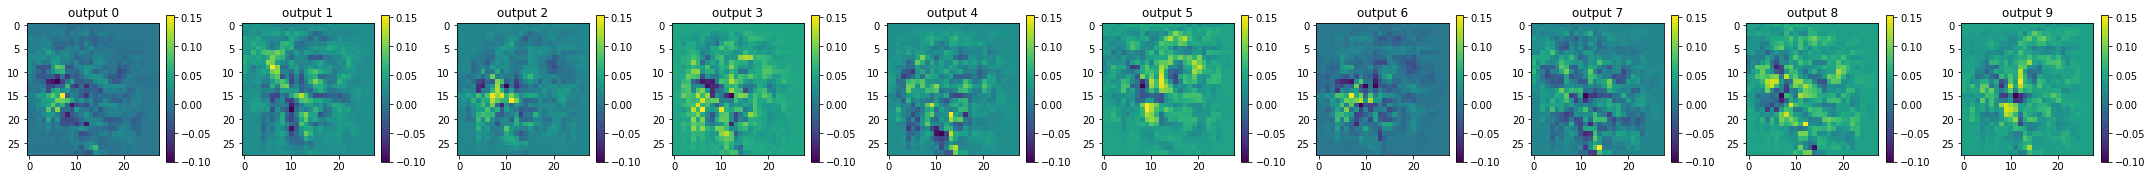

In [16]:
fig, ax = plt.subplots(1,num_classes, figsize=(30,30))
for i in range(num_classes):
    ax[i].imshow(Jacobian_matrix[i])
    ax[i].set_title(f'output {i}')
    _ = fig.colorbar(im,ax=ax[i], fraction=0.05)
plt.tight_layout()

Again we can see that the main attention is on the center of the images. Note that unlike the linear model the attention pattern varies by input (change the "index" variable and check it out), because the model is more complex and potentially can perform better through a more subtle implicit attention.